Here we seek to solve
\begin{align}
\min_{(u,m)\in\mathcal{V}\times\mathcal{M}}J(u,m)&=\frac{1}{2}||u-u_{d}||_{L^{2}(\Omega)}^{2}+\frac{1}{2}R(m)\\
R(m)&=\gamma_{1}||m||_{L^{2}(\Omega)}^{2}+\gamma_{2}||\nabla m||_{L^{2}}^{2}
\end{align}

subject to the partial differential equality constraint

\begin{align*}
-\nabla\cdot\left(m\,\nabla u\right)+\beta\, u&=f,\,\,\,\text{ in }\Omega \\
\frac{\partial u}{\partial n}&=0,\,\,\,\text{ on }\partial\Omega
\end{align*}

and the bound constraint

\begin{align*}
m(x)\geq m_{\ell}(x)>0,\,\,\,\text{ on }\overline{\Omega}
\end{align*}

here $\beta\in\mathbb{R}$, $f:\Omega\rightarrow\mathbb{R}$, $u_{d}:\Omega\rightarrow\mathbb{R}$, $m_{\ell}:\overline{\Omega}\rightarrow\mathbb{R}_{>0}$, $\lbrace \gamma_{j}\rbrace_{j=1}^{2}\subset\mathbb{R}$ are given.



In [1]:
"""
case = 1, solve the inverse problem
case = 2, verify first-order derivatives
case = 3, verify second-order derivatives
"""

case = 1

In [2]:
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import dolfin as dl
import nb as nb

# False - natural ordering; True - interlace
dl.parameters['reorder_dofs_serial'] = False

import matplotlib.pyplot as plt
import cyipopt

In [3]:
plt.style.use('classic')
plt.rcParams.update({'font.size': 16})

In [4]:
def csr_fenics2scipy(A_fenics):
    ai, aj, av = dl.as_backend_type(A_fenics).mat().getValuesCSR()
    A_scipy = sps.csr_matrix((av, aj, ai))
    return A_scipy

def coo_fenics2scipy(A_fenics):
    A_coo = csr_fenics2scipy(A_fenics).tocoo()
    return A_coo

class Boundary(dl.SubDomain):
    def inside(me, x, on_boundary):
        return on_boundary

    
"""
An object which will internally handle the finite-element
discretization of the infinite-dimensional inverse problem
and set up the linear KKT system.
"""    

class inverseDiffusion:
    def __init__(me, Vh, beta, gamma1, gamma2, ud, f):
        """
        Product finite-element space for the state and parameter 
        """
        me.Vh    = Vh
        
        # size of operator
        me.n     = me.Vh.dim()
        # first idx indices correspond to state others to parameter
        me.idx   = me.Vh.sub(0).dim()
        # data that we are fitting the model to
        me.ud    = ud
        me.udnp  = ud.vector().get_local()[:]
        # rhs
        me.f = f
        # parameter entering left hand side of PDE
        me.beta   = beta
        # regularization parameters
        me.gamma1  = gamma1
        me.gamma2  = gamma2
        
        utest, mtest   = dl.TestFunctions(me.Vh)
        utrial, mtrial = dl.TrialFunctions(me.Vh)
        Rform          = (dl.Constant(gamma1)*mtest*mtrial + \
                         dl.Constant(gamma2)*dl.inner(dl.grad(mtest), dl.grad(mtrial)))*dl.dx(me.Vh.mesh())
        me.R = csr_fenics2scipy(dl.assemble(Rform))[me.idx:,me.idx:]
        
        me.Mform       = (utest*utrial + mtest*mtrial)*dl.dx(me.Vh.mesh())
        me.Mx          = csr_fenics2scipy(dl.assemble(me.Mform))
        me.Mu          = me.Mx[:me.idx,:me.idx]
        
        
        # sparsity structure of the Hessian
        me.Hrows   = None
        me.Hcols   = None
        me.Hidxs    = []
        
        # sparsity structure of the constraint Jacobian
        me.Jrows   = None
        me.Jcols   = None
        me.Jidxs   = []
        
    """
    In what follows x will be a function on the state-parameter product
    finite-element space
    """
    
    def setstructure(me, x, p):
        """ 
        get structure of any form on the product space
        sparsity pattern determined by the function space,
        supports of basis functions, etc, not by the particular structure
        of a form
        """
        M = coo_fenics2scipy(dl.assemble(me.Mform))
        rows = M.row
        cols = M.col
        
        # do not take any elements above the diagonal as they are repeated in ipopt
        for i in range(len(rows)):
            if cols[i] <= rows[i]:
                me.Hidxs.append(i)
        me.Hrows = rows[me.Hidxs]
        me.Hcols = cols[me.Hidxs]
        
        # do not take all rows for the Jacobian structure
        for i in range(len(rows)):
            if rows[i] < me.Vh.sub(0).dim():
                me.Jidxs.append(i)
        me.Jrows = rows[me.Jidxs]
        me.Jcols = cols[me.Jidxs]
        
        
    
    """
    objective -- return the value of the regularized data-misfit functional at x
    """
    def objective(me, x):
        diff = x[:me.idx] - me.udnp[:]
        return 0.5 * np.inner(x[me.idx:], me.R.dot(x[me.idx:])) + 0.5 * np.inner(diff, me.Mu.dot(diff))
    """
    gradient -- return the variational derivative of J with respect to x
    """
    def gradient(me, x):
        diff = x[:me.idx] - me.udnp[:]
        return np.concatenate((me.Mu.dot(diff), me.R.dot(x[me.idx:])))
    def DxxJform(me, x):
        utest, mtest = dl.TestFunctions(me.Vh)
        utrial, mtrial = dl.TrialFunctions(me.Vh)
        return (utrial*utest + \
                                dl.Constant(me.gamma1)*\
                                mtrial*mtest + \
                                dl.Constant(me.gamma2)*\
                                dl.inner(dl.grad(mtest), dl.grad(mtrial)))*dl.dx(me.Vh.mesh())
    """ 
    return the second variational derivative of J with respect to x, that is 
    a linear mapping from primal to dual 
    """
    def DxxJ(me, x):
        return dl.assemble(me.DxxJform(x))
    """
    constraints -- evaluate the PDE-constraint at x, returning a dual-vector 
    """    
    def constraints(me, x):
        X = dl.Function(me.Vh)
        X.vector().set_local(x)
        utest, mtest = dl.TestFunctions(me.Vh)
        return dl.assemble((X.sub(1)*dl.inner(dl.grad(X.sub(0)), dl.grad(utest)) + \
                            dl.Constant(me.beta)*X.sub(0)*utest - me.f*utest)*dl.dx(me.Vh.mesh()))\
                            .get_local()[:me.idx]
    """
    evaluate the variational derivative of the PDE-constraint with respect
    to x, 
    return a linear mapping from the primal to the dual
    """
    def jacobianform(me, x):
        X = dl.Function(me.Vh)
        X.vector().set_local(x)
        p, _ = dl.TestFunctions(me.Vh)
        utrial, mtrial = dl.TrialFunctions(me.Vh)
        return (X.sub(1)*dl.inner(dl.grad(utrial), dl.grad(p)) + \
                                mtrial*dl.inner(dl.grad(X.sub(0)), dl.grad(p))+ dl.Constant(me.beta)*utrial*p)*\
                               dl.dx(me.Vh.mesh())
    
    def jacobian(me, x):
        Jac = coo_fenics2scipy(dl.assemble(me.jacobianform(x)))
        return (Jac.data)[me.Jidxs]
    def Dxxcpform(me, x, p):
        X = dl.Function(me.Vh)
        P = dl.Function(me.Vh)
        P.vector().vec()[:me.idx] = p[:]
        X.vector().set_local(x)
        utest, mtest   = dl.TestFunctions(me.Vh)
        utrial, mtrial = dl.TrialFunctions(me.Vh)
        return (mtest * dl.inner(dl.grad(utrial), dl.grad(P.sub(0))) + \
                                             mtrial * dl.inner(dl.grad(utest), dl.grad(P.sub(0))))*\
                                            dl.dx(me.Vh.mesh())
    def Dxxcp(me, x, p):
        return dl.assemble(me.Dxxcpform(x, p))
    def hessianstructure(me):
        return me.Hrows, me.Hcols
    def jacobianstructure(me):
        return me.Jrows, me.Jcols
    def hessian(me, x, p, obj_fac):
        H = coo_fenics2scipy(dl.assemble(obj_fac * me.DxxJform(x) + me.Dxxcpform(x,p)))
        return (H.data)[me.Hidxs]
    def intermediate(
            self,
            alg_mod,
            iter_count,
            obj_value,
            inf_pr,
            inf_du,
            mu,
            d_norm,
            regularization_size,
            alpha_du,
            alpha_pr,
            ls_trials
            ):

        #
        # Example for the use of the intermediate callback.
        #
        print("Barrier parameter value at iteration #%d is - %g" % (iter_count, mu))
        print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))


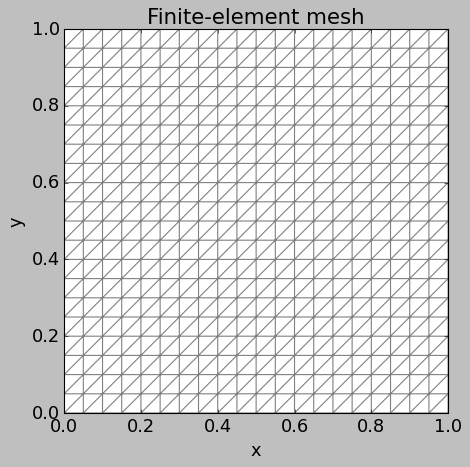

In [5]:
"""
Define a mesh over the unit-square.
Since finite-difference verification of 
the first and second order derivatives is slow,
make the mesh very coarse for these cases.
"""

if case == 1:
    nx = 20
else:
    nx = 2

mesh = dl.UnitSquareMesh(nx, nx)
dl.plot(mesh)
plt.title('Finite-element mesh')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [6]:
P1 = dl.FiniteElement("CG", mesh.ufl_cell(), 1)
P2 = dl.FiniteElement("CG", mesh.ufl_cell(), 2)
Th = dl.MixedElement([P2, P1])
Vh = dl.FunctionSpace(mesh, Th)
Vh1 = dl.FunctionSpace(mesh, P1)
Vh2 = dl.FunctionSpace(mesh, P2)

print("state dim = {0:d}, parameter dimension = {1:d}".format(Vh2.dim(), Vh1.dim()))

state dim = 1681, parameter dimension = 441


In [7]:
beta   = 1.e0
gamma1  = 1.e-3
gamma2 = 1.e-3
Cml = 0.75
ml  = dl.interpolate(dl.Expression('C', element=Vh1.ufl_element(), C=Cml), Vh1)
ud  = dl.interpolate(dl.Expression('std::cos(x[0]*pi)*std::cos(x[1]*pi)',\
                                      pi=np.pi, element=Vh2.ufl_element()), Vh2)
f   = dl.interpolate(dl.Expression('(2.*pi*pi*(0.5+x[0]) + beta)*std::cos(x[0]*pi)*std::cos(x[1]*pi)'+\
                                      '+pi*std::sin(pi*x[0])*std::cos(pi*x[1])',\
                                       pi=np.pi, beta=beta, element=Vh2.ufl_element()), Vh2)

mtrue = dl.interpolate(dl.Expression('0.5+x[0]',\
                                     element=Vh1.ufl_element()), Vh1)

In [8]:
# initial point for optimization and used for deriative tests
x0 = [1.+np.random.randn() if i < Vh2.dim() \
      else (abs(np.random.randn())+1. + ml.vector()[i-Vh2.dim()]) for i in range(Vh.dim())]

In [9]:
inverse = inverseDiffusion(Vh, beta, gamma1, gamma2, ud, f)

xsetstructure = 1. + np.abs(np.random.randn(Vh.dim()))
psetstructure = np.random.randn(Vh2.dim())
inverse.setstructure(xsetstructure, psetstructure)

In [10]:
# lower and upper bound constraints
lb = [-2.0e19 if i < Vh2.dim() else ml.vector()[i-Vh2.dim()] for i in range(Vh.dim())]
ub = [2.0e19 for i in range(Vh.dim())]

# constraint lower and upper bounds
cl = [0. for _ in range(Vh2.dim())]
cu = [0. for _ in range(Vh2.dim())]

nlp = cyipopt.Problem(n=Vh.dim(), m=Vh2.dim(), problem_obj=inverse, lb=lb, ub=ub, cl=cl,cu=cu)

In [11]:
if case == 1:
    nlp.add_option('mu_strategy', 'adaptive')
    nlp.add_option('tol', 1.e-8)
    nlp.add_option('max_iter', 200)
elif case == 2:
    print("-"*20 + "FIRST ORDER DERIVATIVE CHECK"+"-"*20)
    nlp.add_option('derivative_test', 'first-order')
    nlp.add_option('derivative_test_perturbation', 1.e-6)
    nlp.add_option('max_iter', 0)
elif case == 3:
    print("-"*20 + "SECOND ORDER DERIVATIVE CHECK"+"-"*20)
    nlp.add_option('derivative_test', 'only-second-order')
    nlp.add_option('derivative_test_perturbation', 1.)
    nlp.add_option('max_iter', 0)

x, info = nlp.solve(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    26522
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    19683

Total number of variables............................:     2122
                     variables with only lower bounds:      441
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1681
Total number of inequality co

### Display optimal fields if an optimum was saught

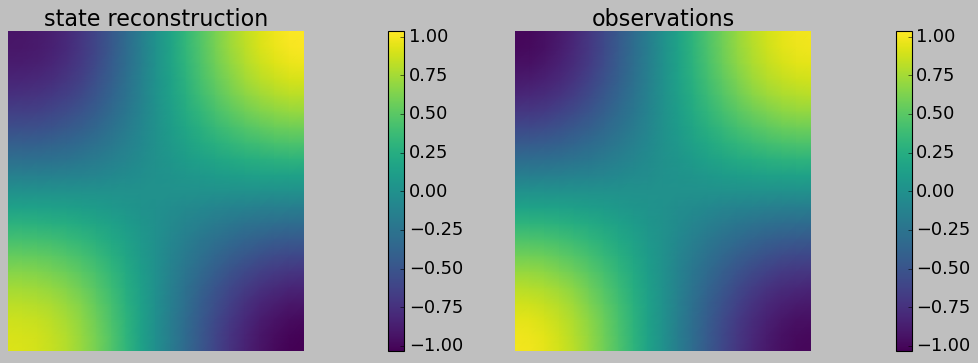

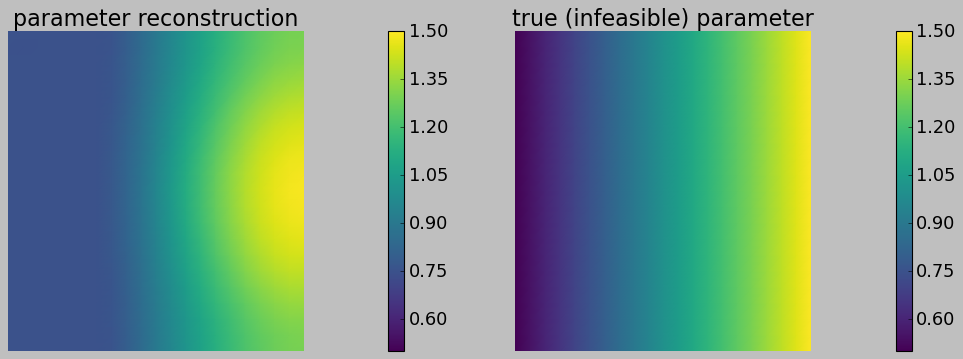

In [12]:
if case == 1:
    uReconstruction = dl.Function(Vh2)
    mReconstruction = dl.Function(Vh1)
    uReconstruction.vector().set_local(x[:Vh2.dim()])
    mReconstruction.vector().set_local(x[Vh2.dim():])
    nb.multi1_plot([uReconstruction, ud], ["state reconstruction", "observations"])
    plt.show()
    nb.multi1_plot([mReconstruction, mtrue], ["parameter reconstruction", "true (infeasible) parameter"])
    plt.show()